In [175]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import csv
import os
import os.path
from pathlib import Path
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
import pickle
from matplotlib import pyplot
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from IPython.display import display
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from time import gmtime, strftime
from jupyterthemes import jtplot
import re
import gc
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
from sklearn.model_selection import StratifiedShuffleSplit

from functools import partial
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from skopt import gp_minimize
from skopt import space 

import shap
shap.initjs()

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

pd.options.display.max_columns=1000
pd.options.display.max_rows=300
pd.set_option('display.float_format', lambda x: '%.3f' % x)
gc.collect()


31039

In [2]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


#Move Specified column to last
def move_to_last(df,column):
    churn=df[column]
    df_lst=df.drop([column],axis=1)
    df_lst=pd.concat([df_lst,churn],axis=1)
    return df_lst

#Computing AUC
def auc_curve(df,ytest,qtr,model_name):
    #Ploting AUC curve.
    y_pred = df['prob'].values
    ns_probs =[0 for _ in range(len(ytest))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(ytest, y_pred)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=str(model_name)+str(qtr))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    print(str(qtr)+ str(model_name)+ "ROC-AUC score is: ", (roc_auc_score(ytest, y_pred))*100)

#Computing Precision Recall Curve
def pre_rec_curve(tdf,actual,qtr):
    y_pred = tdf['prob'].values
    lr_precision, lr_recall, _ = precision_recall_curve(actual, y_pred)
    lr_auc =  auc(lr_recall, lr_precision)
    # summarize scores
    print('LightGBM '+str(qtr)+' : precision recal curve=%.3f' % ( lr_auc))
    # plot the precision-recall curves
    no_skill = len(actual[actual==4]) / len(actual)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label='LighGBM '+str(qtr))
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

#Defining highest F1 Score
def f1_thershold(Pred,Actual,fold):
    Thres_list=[]
    f1_list=[]
    fold_list=[]
    for x in np.arange(.1,.9,0.005):
            y_pred=np.where(Pred>x,1,0)
            Thres_list.append(x)
            f1_list.append(f1_score(Actual,y_pred, average='macro'))
            fold_list.append(fold)
            Thres_df = pd.DataFrame(list(zip(Thres_list,f1_list,fold_list)),columns =['Threshold','F1score','fold'])
            max_f1=Thres_df.F1score.max()
            Thres_df=Thres_df[Thres_df['F1score']==max_f1]
    return(Thres_df)

#Computing Confusion Matrix
def conf_matr(tdf,actual,cut_off):
    #Confusion matrix for 21Q1
    y_pred =np.where(tdf['prob'].values>cut_off,1,0)
    print(confusion_matrix(actual,y_pred))
    #extracting true_positives, false_positives, true_negatives, false_negatives
    tn, fp, fn, tp = confusion_matrix(actual,y_pred).ravel()
    print("True Negatives: ",tn)
    print("False Positives: ",fp)
    print("False Negatives: ",fn)
    print("True Positives: ",tp)
    print('Accuracy:' ,accuracy_score(actual,y_pred))
    print(classification_report(actual,y_pred))

In [176]:
#os.getcwd()
#Setting data directory
data_dir = Path('..','iim_apds_churn_prjct')

data_path=Path(data_dir,'data/satish/prep_telo_df.csv')
telo_df=pd.read_csv(data_path)
telo_df.head()

,Customer_ID,churn,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,blck_vce_Mean,unan_vce_Mean,plcd_dat_Mean,custcare_Mean,threeway_Mean,iwylis_vce_Mean,callwait_Mean,months,uniqsubs,actvsubs,totcalls,totrev,hnd_price,phones,truck,lor,adults,income,numbcars,eqpdays,fe_mean_per_minute_charge,fe_tot_revenue_per_call,fe_tot_mou_per_call,fe_tot_revenue_adj,fe_tot_mou_adj,HHstatin_A,HHstatin_B,HHstatin_C,HHstatin_G,HHstatin_I,HHstatin_Missing,area_ATLANTIC_SOUTH_AREA,area_CALIFORNIA_NORTH_AREA,area_CENTRAL_SOUTH_TEXAS_AREA,area_CHICAGO_AREA,area_DALLAS_AREA,area_DC_MARYLAND_VIRGINIA_AREA,area_GREAT_LAKES_AREA,area_HOUSTON_AREA,area_LOS_ANGELES_AREA,area_MIDWEST_AREA,area_NEW_ENGLAND_AREA,area_NEW_YORK_CITY_AREA,area_NORTH_FLORIDA_AREA,area_NORTHWEST_ROCKY_MOUNTAIN_AREA,area_OHIO_AREA,area_PHILADELPHIA_AREA,area_SOUTH_FLORIDA_AREA,area_SOUTHWEST_AREA,area_TENNESSEE_AREA,asl_flag_N,asl_flag_Y,crclscod_A,crclscod_AA,crclscod_B,crclscod_BA,crclscod_C,crclscod_CA,crclscod_DA,crclscod_EA,crclscod_ZA,creditcd_Missing,creditcd_N,creditcd_Y,dualband_N,dualband_T,dualband_Y,dwllsize_A,dwllsize_B,dwllsize_C,dwllsize_J,dwllsize_Missing,dwllsize_O,dwlltype_M,ethnic_B,ethnic_F,ethnic_G,ethnic_H,ethnic_I,ethnic_J,ethnic_N,ethnic_O,ethnic_R,ethnic_S,ethnic_U,ethnic_Z,hnd_webcap_Missing,hnd_webcap_WC,hnd_webcap_WCMB,infobase_M,infobase_Missing,kid0_2_U,kid0_2_Y,kid11_15_U,kid11_15_Y,kid16_17_U,kid16_17_Y,kid3_5_U,kid3_5_Y,kid6_10_U,kid6_10_Y,marital_A,marital_B,marital_M,marital_S,marital_U,new_cell_N,new_cell_U,new_cell_Y,ownrent_Missing,ownrent_O,ownrent_R,prizm_social_one_C,prizm_social_one_Missing,prizm_social_one_R,prizm_social_one_S,prizm_social_one_T,prizm_social_one_U,refurb_new_N,refurb_new_R
0,1000001,1,25.115,219.250,22.500,0.247,0.000,0.000,-157.250,-18.997,0.667,0.667,6.333,0.000,0.000,0.000,0.000,0.333,33.000,2.000,1.000,1652.000,1504.620,149.990,2.000,0.000,13.000,1.000,4.000,2.000,361.000,9.136,0.911,2.559,51.180,143.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
1,1000002,0,57.492,482.750,37.425,0.247,22.750,0.000,205.750,22.223,8.333,1.000,61.333,0.000,1.667,0.333,6.333,4.667,33.000,1.000,1.000,6202.000,1914.998,109.757,3.000,1.000,1.000,1.000,5.000,1.000,240.000,8.397,0.208,1.815,31.920,33.000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
2,1000003,1,25.115,48.325,18.545,0.000,0.000,0.000,-4.250,0.000,0.333,0.000,2.667,0.000,0.000,0.000,0.000,0.000,33.000,1.000,1.000,6202.000,1914.998,29.990,2.000,0.000,7.000,2.000,5.000,2.000,742.000,1.551,0.273,3.086,113.540,82.003,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,1000004,0,38.000,48.325,38.000,0.000,0.000,0.000,-1.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,33.000,1.000,1.000,1502.000,1914.998,29.990,1.000,0.000,6.000,4.000,6.000,1.000,742.000,1.551,1.268,2.041,59.090,30.000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0
4,1000005,0,55.230,570.500,71.980,0.000,0.000,0.000,38.500,0.000,9.667,0.667,67.333,0.000,5.333,0.000,0.667,0.000,33.000,1.000,1.000,4485.000,1914.998,149.990,3.000,0.000,5.000,1.000,6.000,1.000,434.000,10.330,0.486,3.128,31.920,63.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0


In [166]:
# Dividing the Train and Test Split
X=telo_df.drop(['churn'],axis=1)
y=telo_df['churn']

scaler = MinMaxScaler()
telo_df=scaler.fit_transform(telo_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

id_train=X_train
id_test=X_test

X_Fe_train=X_train.drop(['Customer_ID'],axis=1)
X_train=X_train.drop(['Customer_ID'],axis=1)

scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)

X_test=X_test.drop(['Customer_ID'],axis=1)
X_test=scaler.fit_transform(X_test)

In [167]:

#Logistic Regression Clasifier
logreg = LogisticRegression(solver='lbfgs',
                            class_weight='balanced',
                            penalty='l2')
logreg.fit(X_train, y_train)

lbfgs failed to converge. Increase the number of iterations.


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

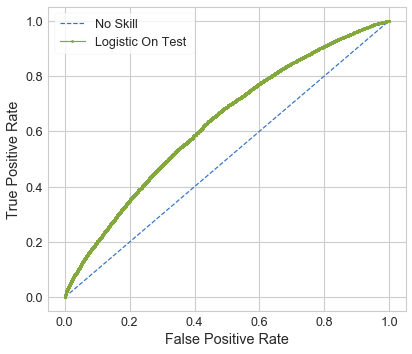

On Test Logistic ROC-AUC score is:  63.07534289060509


In [168]:
telco_test = pd.DataFrame()
telco_test['Customer_ID']=id_test['Customer_ID']
telco_test['prob']=logreg.predict_proba(X_test)[:,1]
auc_curve(telco_test,y_test,'On Test ','Logistic ')


In [169]:
conf_matr(telco_test,y_test,0.5)

[[8916 6162]
 [6041 8881]]
True Negatives:  8916
False Positives:  6162
False Negatives:  6041
True Positives:  8881
Accuracy: 0.5932333333333333
              precision    recall  f1-score   support

           0       0.60      0.59      0.59     15078
           1       0.59      0.60      0.59     14922

    accuracy                           0.59     30000
   macro avg       0.59      0.59      0.59     30000
weighted avg       0.59      0.59      0.59     30000



In [ ]:
On Test Logistic ROC-AUC score is:  63.23568883149694
On Test Logistic ROC-AUC score is:  63.364424326779975

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


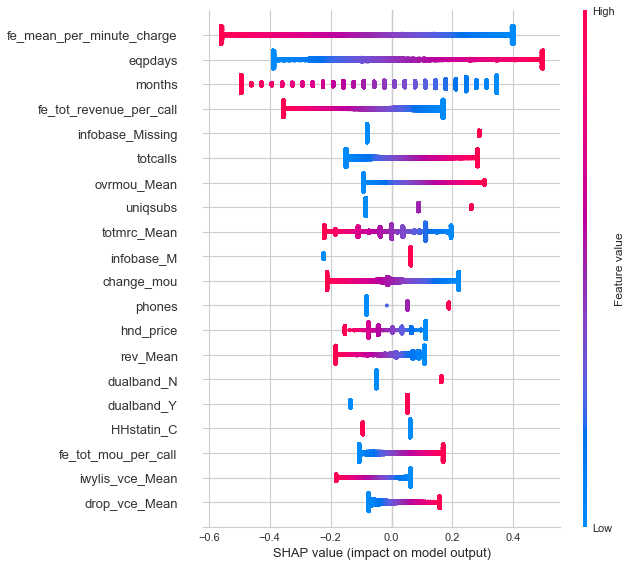

In [170]:
#Shap for Logistic
explainer = shap.LinearExplainer(logreg, X_train, feature_dependence="independent")
logreg_shap=explainer.shap_values(X_train)
shap.summary_plot(logreg_shap, X_train, plot_type = "dot",feature_names=X_Fe_train.columns)

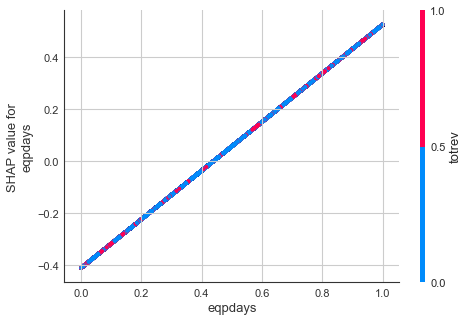

In [50]:
shap.dependence_plot("eqpdays", logreg_shap, X_train,feature_names=X_Fe_train.columns)

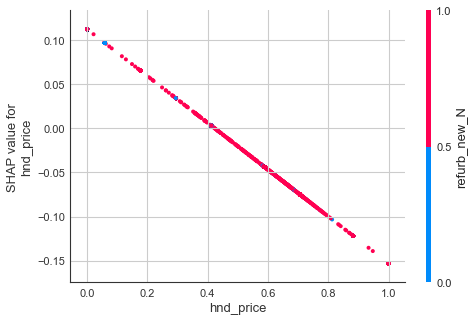

In [172]:
shap.dependence_plot("hnd_price", logreg_shap, X_train,feature_names=X_Fe_train.columns)

In [58]:
#shap.force_plot(explainer.expected_value, logreg_shap[0,:], X_train.iloc[0,:])


ind = 4
shap.force_plot(
    explainer.expected_value, logreg_shap[ind,:], X_Fe_train.iloc[ind,:],
    feature_names=X_Fe_train.columns
)

In [ ]:
#Data load for random forest.

X=telo_df.drop(['churn'],axis=1)
y=telo_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1000)

id_train=X_train
id_test=X_test

X_train=X_train.drop(['Customer_ID'],axis=1)
X_test=X_test.drop(['Customer_ID'],axis=1)


In [151]:
#Random Forest

rf_clf =RandomForestClassifier(random_state=42, oob_score = True, n_jobs= -2, 
                              class_weight  = 'balanced', max_depth = 30,
                              n_estimators = 800, criterion = 'gini',
                              max_features = 'auto', verbose = 1)
rf_clf.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-2)]: Done 428 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-2)]: Done 778 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-2)]: Done 800 out of 800 | elapsed:   48.9s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=800, n_jobs=-2, oob_score=True,
                       random_state=42, verbose=1, warm_start=False)

[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.4s
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed:    1.0s
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed:    1.8s
[Parallel(n_jobs=11)]: Done 800 out of 800 | elapsed:    1.9s finished


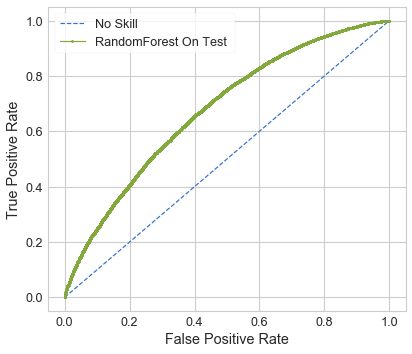

On Test RandomForest ROC-AUC score is:  67.82404232780186


In [152]:
telco_test = pd.DataFrame()
telco_test['Customer_ID']=id_test['Customer_ID']
telco_test['prob']=rf_clf.predict_proba(X_test)[:,1]
auc_curve(telco_test,y_test,'On Test ','RandomForest ')

In [153]:
conf_matr(telco_test,y_test,0.5)

[[8911 6287]
 [4932 9870]]
True Negatives:  8911
False Positives:  6287
False Negatives:  4932
True Positives:  9870
Accuracy: 0.6260333333333333
              precision    recall  f1-score   support

           0       0.64      0.59      0.61     15198
           1       0.61      0.67      0.64     14802

    accuracy                           0.63     30000
   macro avg       0.63      0.63      0.63     30000
weighted avg       0.63      0.63      0.63     30000



In [ ]:
On Test RandomForest ROC-AUC score is:  67.979692705267
On Test RandomForest ROC-AUC score is:  67.72893711901806

In [59]:
#Hyperparameter tunining for Random Forest:

def optimze(params,x,y):
    model=RandomForestClassifier(**params)
    
    #Intialize  K-Fold cv
    kf=KFold(n_splits=5)
    
    auc=[]
    
    for idx in kf.split(X=x,y=y):
        train_idx,test_idx=idx[0],idx[1]
        xtrain=x[train_idx]
        ytrain=y[train_idx]
        
        xtest=x[test_idx]
        ytest=y[test_idx]
        
        model.fit(xtrain,ytrain)
        
        preds=model.predict(xtest)
        
        fold_accuracy=roc_auc_score(ytest,preds)
        auc.append(fold_accuracy)
        
    return -1*np.mean(auc)


In [60]:
# Dividing the Train and Test Split
X=telo_df.drop(['churn'],axis=1)
y=telo_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

id_train=X_train['Customer_ID']
id_test=X_test['Customer_ID']

X_train=X_train.drop(['Customer_ID'],axis=1)
X_test=X_test.drop(['Customer_ID'],axis=1)

if __name__=="__main__":
    X=X_train.values
    y=y_train.values
    
    param_space={
        "max_depth":scope.int(hp.quniform("max_depth",6,34,2)),
        "n_estimators":scope.int(hp.quniform("n_estimators",100,1000,100)),
        "criterion": hp.choice("criterion",["gini","entropy"]),
        "max_features":hp.uniform("max_features",0,1)
    }
    
    optimzation_function=partial(
        optimze,
        x=X,
        y=y
        )
    
    trails=Trials()
    
    hopt=fmin(
    fn=optimzation_function,
    space=param_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=trails
    )
    
    
    print(hopt)
    

    
    


100%|█████████████████████████████████████████████| 5/5 [2:24:39<00:00, 1735.85s/trial, best loss: -0.6256139281549602]
{'criterion': 1, 'max_depth': 15.0, 'max_features': 0.7254922455784253, 'n_estimators': 724.0}


In [10]:
#XGBoost 
xgb_clf=xgb.XGBClassifier(n_jobs=-1,
                         max_depth=7,
                         eta=0.015,
                         min_child_weight=4,
                         reg_lambda=0.2,
                         alpha=0.5)

xgb_clf.fit(X_train,y_train)

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.015, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0149999997, max_delta_step=0, max_depth=7,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.5,
              reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

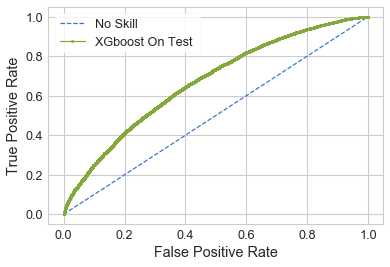

On Test XGboost ROC-AUC score is:  67.16299955707663


In [11]:
telco_test = pd.DataFrame()
telco_test['Customer_ID']=id_test
telco_test['prob']=xgb_clf.predict_proba(X_test)[:,1]
auc_curve(telco_test,y_test,'On Test ','XGboost ')

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

id_train=X_train
id_test=X_test

X_train=X_train.drop(['Customer_ID'],axis=1)
X_test=X_test.drop(['Customer_ID'],axis=1)

#Light GBM

#Complete Model

lgb_clf = LGBMClassifier(
        nthread=4,
        boosting_type='dart',
        dart_subsample= 0.79,
        n_estimators=2000,
        learning_rate=0.015,
        num_leaves=43,
        max_depth=18,
        reg_alpha=0.08,
        reg_lambda=0.36,
        is_unbalance=False,
        silent=-1,
        verbose=-1,
        )


lgb_clf.fit(X_train, y_train,eval_metric= 'auc', verbose= 50, early_stopping_rounds= 100)

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               dart_subsample=0.79, importance_type='split', is_unbalance=False,
               learning_rate=0.015, max_depth=18, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, nthread=4, num_leaves=43, objective=None,
               random_state=None, reg_alpha=0.08, reg_lambda=0.36, silent=-1,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

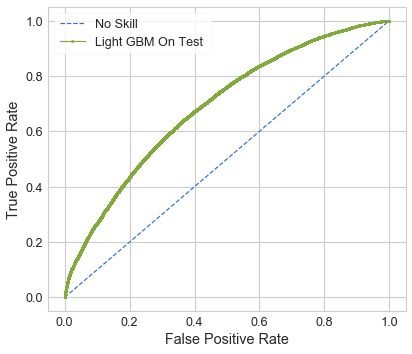

On Test Light GBM ROC-AUC score is:  69.03106025340603


In [178]:
telco_test = pd.DataFrame()
telco_test['Customer_ID']=id_test['Customer_ID']
telco_test['prob']=lgb_clf.predict_proba(X_test,num_iteration=lgb_clf.best_iteration_)[:,1]
auc_curve(telco_test,y_test,'On Test ','Light GBM ')

In [179]:
conf_matr(telco_test,y_test,0.5)

[[9433 5639]
 [5265 9663]]
True Negatives:  9433
False Positives:  5639
False Negatives:  5265
True Positives:  9663
Accuracy: 0.6365333333333333
              precision    recall  f1-score   support

           0       0.64      0.63      0.63     15072
           1       0.63      0.65      0.64     14928

    accuracy                           0.64     30000
   macro avg       0.64      0.64      0.64     30000
weighted avg       0.64      0.64      0.64     30000



In [ ]:
On Test Light GBM ROC-AUC score is:  69.04528762279142
On Test Light GBM ROC-AUC score is:  67.9012780305523
On Test Light GBM ROC-AUC score is:  68.14878259473474

In [183]:
# feature importance
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_Fe_train.columns
feature_importance_df["importance"] = lgb_clf.feature_importances_
    
final_importance = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance.reset_index(inplace=True)

#data_path=Path(data_dir,'data/satish/feature_importnace.csv')
#final_importance.to_csv(data_path,index=False)
final_importance



,feature,importance
0,change_mou,6194
1,months,5778
2,fe_mean_per_minute_charge,4923
3,totmrc_Mean,4871
4,eqpdays,4740
5,change_rev,3406
6,mou_Mean,3378
7,hnd_price,3066
8,fe_tot_revenue_per_call,3060
9,lor,2964


In [66]:
### Adding SHAP Values.
### Assigninig shap from Light GBM Model
lgb_explainer=shap.TreeExplainer(lgb_clf)
lgb_shap=lgb_explainer.shap_values(X_train)

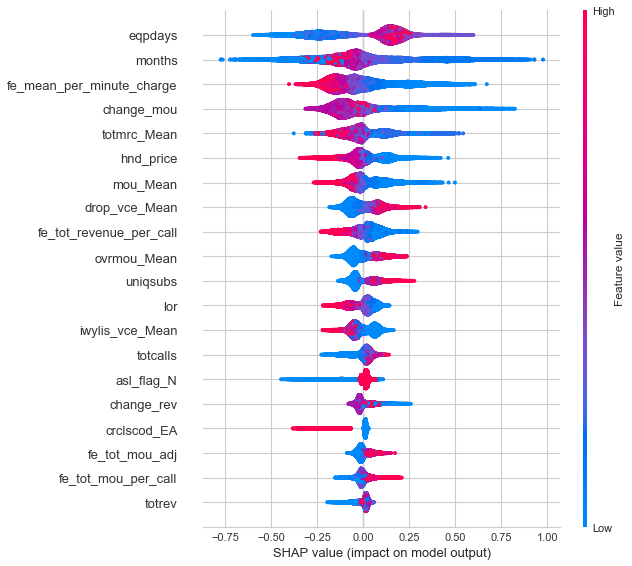

In [67]:
shap.summary_plot(lgb_shap[1], X_train, plot_type = "dot")

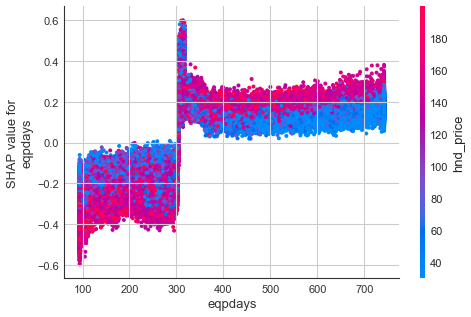

In [74]:
shap.dependence_plot("eqpdays", lgb_shap[1], X_train)

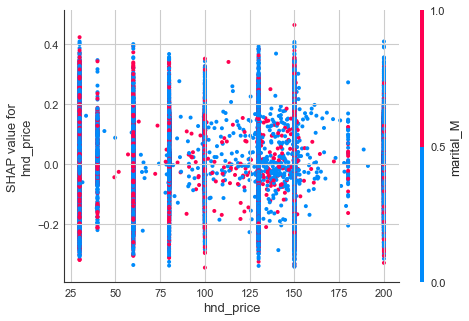

In [159]:
shap.dependence_plot("hnd_price", lgb_shap[1], X_train)

In [125]:
ind=3
#visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)

shap.force_plot(lgb_explainer.expected_value[1],lgb_shap[1][ind], X_train.iloc[ind,:])

In [108]:
lgb_explainer.expected_value

[0.029320483418464736, -0.029320483418464736]

In [62]:
def top_features(df, data_set):
    df = df[df.columns.drop(['abs_sum'])]
    nlargest = 7
    arr = df.to_numpy()
    order = np.argsort(-np.abs(arr), axis=1)[:, :nlargest]
    a = arr[np.arange(arr.shape[0])[:, None], order]
    b = np.abs(a).sum(axis=1)
    result = pd.DataFrame(df.columns[order] + ': ' + a.astype(str) + '%', 
                          columns=['Top{} Contributing Column'.format(i) for i in range(1, nlargest+1)])
    result['Total_Contribution'] = b.tolist()
    
    arr2 = data_set.to_numpy()
    values = arr2[np.arange(arr2.shape[0])[:, None], order]
    result2 = pd.DataFrame(df.columns[order] + ': ' + values.astype(str), 
                          columns=['Top{} Column Values'.format(i) for i in range(1, nlargest+1)])
    
    result_final = pd.concat([result.reset_index(drop=True), result2], axis=1)
    return(result_final)
    
def shap_contribution(data_set, shap_values, pred, id_set):
    df_shap = pd.DataFrame(shap_values[1], columns = data_set.columns.values)
    df_shap['abs_sum'] = df_shap.abs().sum(axis=1)
    df_shap_new = df_shap.div(df_shap["abs_sum"], axis=0) * 100
    #df_shap_new['total_contribution'] = df_shap_new.abs().sum(axis=1)
    df_shap_new = top_features(df_shap_new.round(1), data_set.round(3))
    #df_shap_final = pd.concat([df_shap_new['total_contribution'], df_shap_new], axis=1)
    #df_shap_final = pd.concat([data_set.reset_index(drop=True), df_shap_final], axis=1)
    df_shap_final = pd.concat([id_set['Customer_ID'].reset_index(drop=True), pd.DataFrame({'churn_prediction': pred}), df_shap_new], axis=1)
    
    #print(df_shap_final.head())
    df_shap_final['Total_Contribution'].hist()
    #return (df_shap_final)
    return (df_shap_final)
    #print(df_shap_new.abs().sum(axis=0).sort_values(ascending = False))
    
#df_dummy = shap_contribution(x_lgb_score_21q2_2 ,shap_values_score_21q2, id_score_21q2)
#df_dummy

In [64]:
pred=telco_test['prob']
shap_contribution(X_test,lgb_shap_test,pred,id_test)

Exception: Data must be 1-dimensional